In [1]:
import fastai
from fastai.vision.all import *
import os

In [2]:
def es_correcta(imagen): return imagen[8] == 'B'

In [3]:
path = Path('/home/yani/TFG-Dataset/DatasetConIncorrectas/Tipo3/Completo/')
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.3, bs=9, seed=43,
    label_func=es_correcta
)

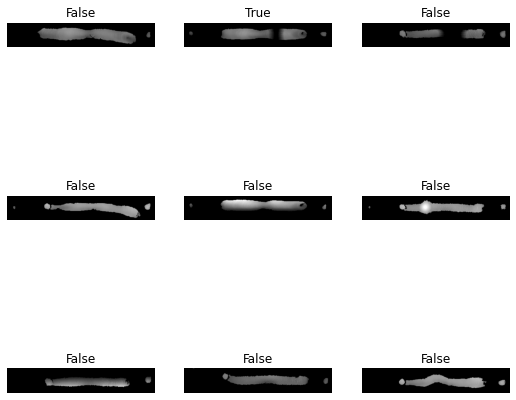

In [4]:
dls.show_batch()

In [5]:
#conv_kwargs = {'kernel_size' : 3, 'padding': 1, 'padding_mode': 'reflect', 'bias': False}
conv_kwargs = {'kernel_size' : 3,'padding':1, 'bias': False}

Las ResNet usan el diseño usado por las VGGs de usar un kernel de tamaño 3x3 que es lo que hacemos aqui.

https://d2l.ai/chapter_convolutional-modern/resnet.html

In [6]:
path=Path('/home/yani/TFG-Dataset/DatasetConIncorrectas/Tipo3/Completo/CompletoBDia_1_Pieza_15_Soldadura_77.png')

In [7]:
from PIL import Image
import numpy
import torchvision
import matplotlib.pyplot as plt

imagen = Image.open(path)
imagen = tensor(imagen)
print(imagen.shape)
# trans = torchvision.transforms.ToTensor()
# imagen = trans(imagen)
# print(imagen.shape)


torch.Size([80, 480])


El shape del tensor es ([canales, alto, ancho])

In [8]:
xb, yb = dls.one_batch()
print(f'Entrada: {xb.shape}, Salida:{yb.shape}')

Entrada: torch.Size([9, 3, 80, 480]), Salida:torch.Size([9])


In [9]:
inp_stem = nn.Sequential(nn.Conv2d(3, 32, stride=2, **conv_kwargs),
                        nn.BatchNorm2d(32),
                        nn.ReLU(),
                        nn.Conv2d(32, 32, stride=1, **conv_kwargs),
                        nn.BatchNorm2d(32),
                        nn.ReLU(),
                        nn.Conv2d(32, 64, stride=1, **conv_kwargs),
                        nn.BatchNorm2d(64),
                        nn.ReLU(),
                        )

torch.Size([9, 64, 40, 240])


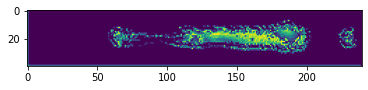

In [34]:
xb = xb.to(device='cpu')
#feature = inp_stem(imagen)
feature = inp_stem(xb)
print(feature.shape)
feature = feature[0][0]
a_imagen = torchvision.transforms.ToPILImage()

feature = a_imagen(feature)

plt.imshow(feature)

### En este punto creamos la clase para los bloques residuales.

In [17]:
class ResidualBlock(nn.Module):
    def __init__(self, canales_entrada, canales_salida, stride=1):
        super().__init__()
        self.canales_entrada = canales_entrada
        self.canales_salida = canales_salida
        #self.stride = stride
        self.id = []
        self.operaciones = nn.Sequential(
            nn.Conv2d(canales_entrada, canales_salida, stride=stride, **conv_kwargs),
            nn.BatchNorm2d(canales_salida), # Mismo tamaño de tensor de salida
            nn.ReLU(), #Mismo tamaño de tensor
            nn.Conv2d(canales_salida, canales_salida, stride=1, **conv_kwargs),
            nn.BatchNorm2d(canales_salida)
        )
        
        if canales_entrada != canales_salida:
            self.id.extend([nn.Conv2d(canales_entrada, canales_salida,
                                      kernel_size=1, padding=0, bias=False),
                           nn.BatchNorm2d(canales_salida)])
        if stride != 1:
            print(self.id)
            #Se ha cambiado stride=2 por stride=stride en el avgpool2d y añadido ceil_mode=True
            self.id = [nn.AvgPool2d(kernel_size = 2, stride=stride, ceil_mode=True)] + self.id
            print(self.id)
        self.id = nn.Sequential(*self.id)
        
    def forward(self, entrada):
        a = self.operaciones(entrada)
        b = self.id(entrada)
        #print(a.shape,b.shape)
        return nn.ReLU()(a + b)

En este caso se ha usado la siguiente estructura para crear el bloque residual. En caso de que el numero de canales de entrada no coincidan con los de salida usamos una convolucion 1x1 para ajustar

<img src="https://d2l.ai/_images/resnet-block.svg" alt="drawing" width="500"/>



torch.Size([9, 64, 40, 240])
torch.Size([9, 128, 40, 240]) torch.Size([9, 128, 40, 240])
torch.Size([9, 128, 40, 240])


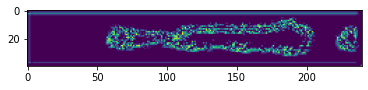

In [36]:

entrada_bloque = inp_stem(xb)
print(entrada_bloque.shape)

res = ResidualBlock(canales_entrada=64, canales_salida=128)
salida_bloque = res.forward(entrada_bloque)

print(salida_bloque.shape)
salida_bloque = a_imagen(salida_bloque[0][0])

plt.imshow(salida_bloque)

En este punto, teniendo los bloques podemos proceder a crear cada una de las fases de la red donde en cada fase se van a usar múltiples bloques. 


<img src="https://i.imgur.com/nyYh5xH.jpg" alt="drawing" width="500"/>

In [18]:
fase1 = nn.Sequential(ResidualBlock(64, 64, stride=1),
                      ResidualBlock(64, 64, stride=1),
                      ResidualBlock(64, 64, stride=1),
                      ResidualBlock(64, 64, stride=1))

fase2 = nn.Sequential(ResidualBlock(64, 128, stride=2),
                      ResidualBlock(128, 128, stride=1),
                      ResidualBlock(128, 128, stride=1),
                      ResidualBlock(128, 128, stride=1))

fase3 = nn.Sequential(ResidualBlock(128, 256, stride=2),
                      ResidualBlock(256, 256, stride=1),
                      ResidualBlock(256, 256, stride=1),
                      ResidualBlock(256, 256, stride=1),
                      ResidualBlock(256, 256, stride=1),
                      ResidualBlock(256, 256, stride=1))

fase4 = nn.Sequential(ResidualBlock(256, 512, stride= 2),
                      ResidualBlock(512, 512, stride=1),
                      ResidualBlock(512, 512, stride=1))
                      

[Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
[AvgPool2d(kernel_size=2, stride=2, padding=0), Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
[Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False), BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
[AvgPool2d(kernel_size=2, stride=2, padding=0), Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False), BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
[Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False), BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
[AvgPool2d(kernel_size=2, stride=2, padding=0), Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False), BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, 

In [38]:
fase1.cuda()
salida_fase1 = fase1(entrada_bloque.cuda())

torch.Size([9, 64, 40, 240]) torch.Size([9, 64, 40, 240])
torch.Size([9, 64, 40, 240]) torch.Size([9, 64, 40, 240])
torch.Size([9, 64, 40, 240]) torch.Size([9, 64, 40, 240])
torch.Size([9, 64, 40, 240]) torch.Size([9, 64, 40, 240])


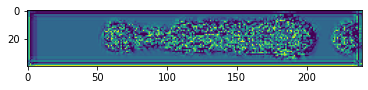

In [39]:
salida_fase1.shape
salida_imagen = salida_fase1
plt.imshow(a_imagen(salida_imagen[0][0]))

In [40]:
print(salida_fase1.shape)
fase2.cuda()
salida_fase2 = fase2(salida_fase1.cuda())


torch.Size([9, 64, 40, 240])


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 3.82 GiB total capacity; 1.37 GiB already allocated; 4.88 MiB free; 2.36 GiB reserved in total by PyTorch)

In [ ]:
from matplotlib.image import imread
salida_imagen2 = salida_fase2
plt.imshow(a_imagen(salida_imagen2[0][0]))


In [19]:
istalinet = nn.Sequential(
                     inp_stem,
                     nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                     fase1,
                     fase2,
                     fase3,
                     fase4,
                     nn.AdaptiveAvgPool2d(1),
                     nn.Flatten(),
                     nn.Linear(512, 256),
                     nn.Linear(256,10),
                     nn.Linear(10,2)
)

In [13]:
def kaiming_init(m):
    if getattr(m, 'bias' , None) is not None:
        m.bias.data.zero_()
    if getattr(m, 'weight', None) is not None:
        if not isinstance(m, nn.BatchNorm2d):
            nn.init.kaiming_normal_(m.weight)
        for l in m.children():
            kaiming_init(1)

In [15]:
torch.cuda.empty_cache()
import gc
gc.collect()

19052

In [14]:
if torch.cuda.is_available():
    istalinet.to(device= 'cuda')


In [20]:
kaiming_init(istalinet)

In [21]:
learn = Learner(dls, istalinet, metrics=accuracy)

## El tamaño del tensor a y b en el bloque residual cuando se aplica la relu no coincide en la altura de la imagen. Ambos caminos por los que entra en tensor no devuelve el mismo resultado en cuanto al shape del tensor

SuggestedLRs(lr_min=7.585775892948732e-06, lr_steep=6.30957365501672e-05)

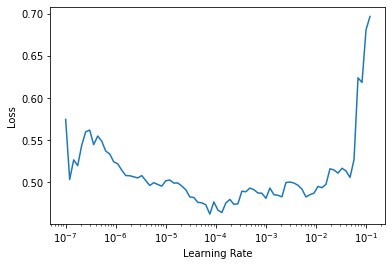

In [22]:
learn.lr_find()

In [24]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.434479,0.413508,0.840959,02:05
1,0.346985,0.317732,0.840959,02:07
2,0.287492,0.277427,0.840959,02:10
3,0.259615,0.269919,0.845938,02:10


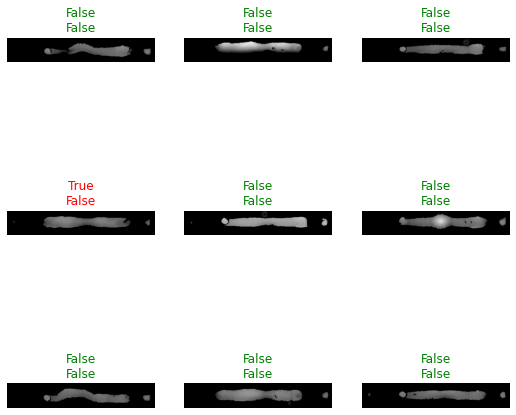

In [25]:
learn.show_results()

In [26]:
learn.summary()

Sequential (Input shape: 9)
Layer (type)         Output Shape         Param #    Trainable 
                     9 x 32 x 40 x 240   
Conv2d                                    864        True      
BatchNorm2d                               64         True      
ReLU                                                           
Conv2d                                    9216       True      
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     9 x 64 x 40 x 240   
Conv2d                                    18432      True      
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               1